I have used the following methods.

* I tried to implementation of distributed deep learning strategy,
* I fine-tuned a pretrained <b>Swin transformer model</b>,
* Used <b>tf.data</b> for input pipeline,
* 3 <b>KFold cross validation</b>,
* Used data augmentation method,


## Prediction Pipeline
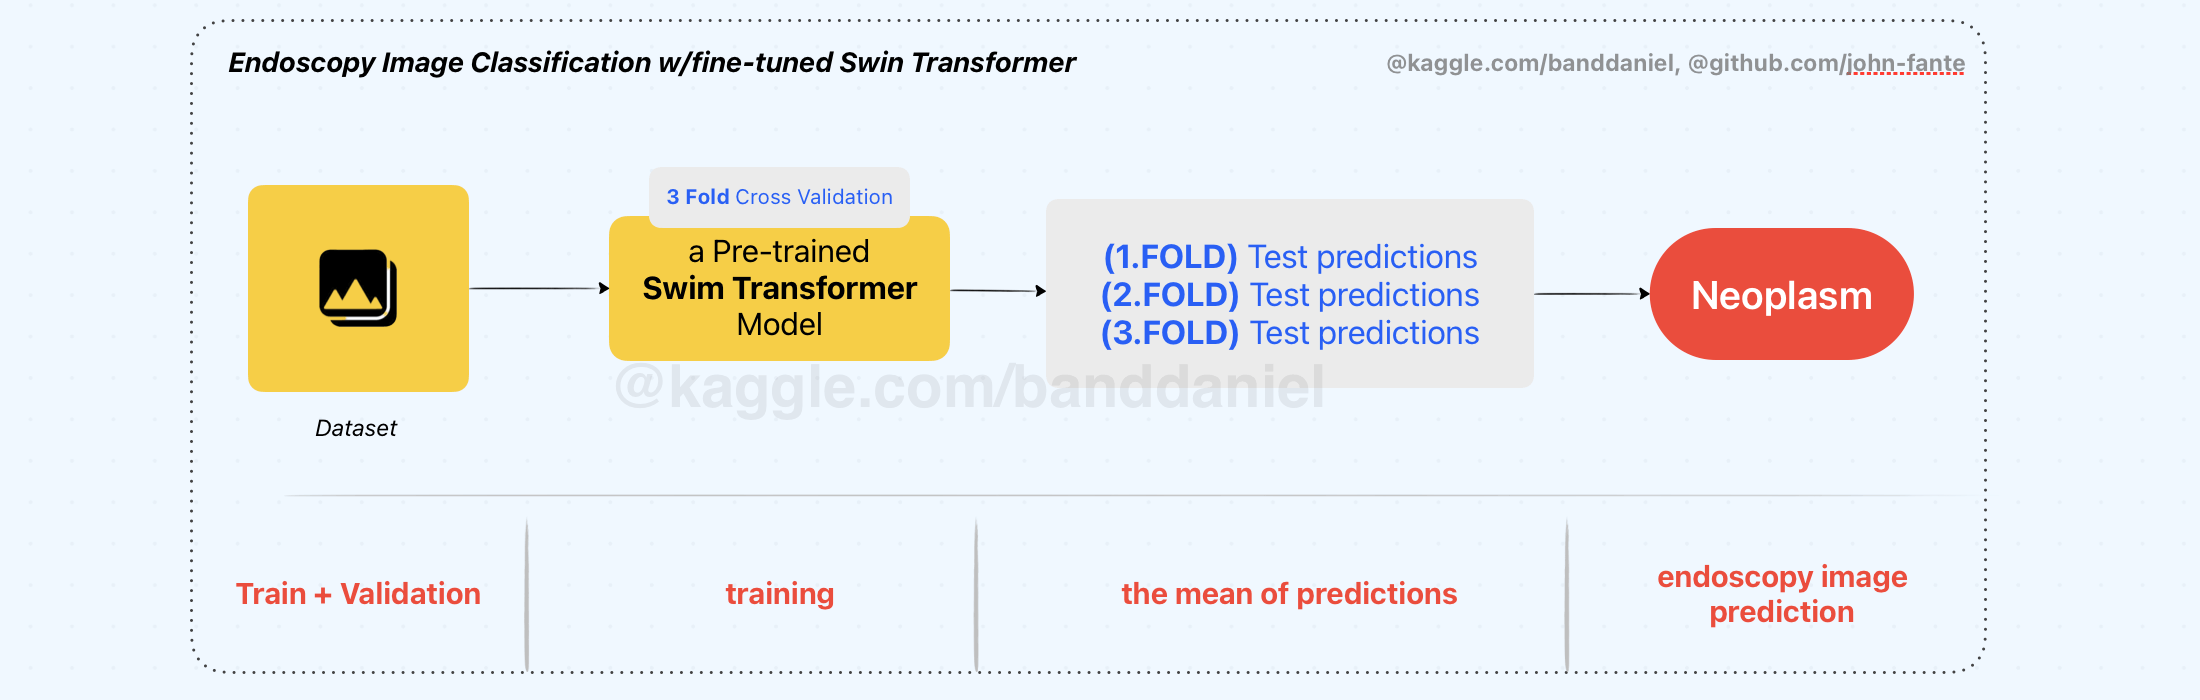

<br>

## Predictions
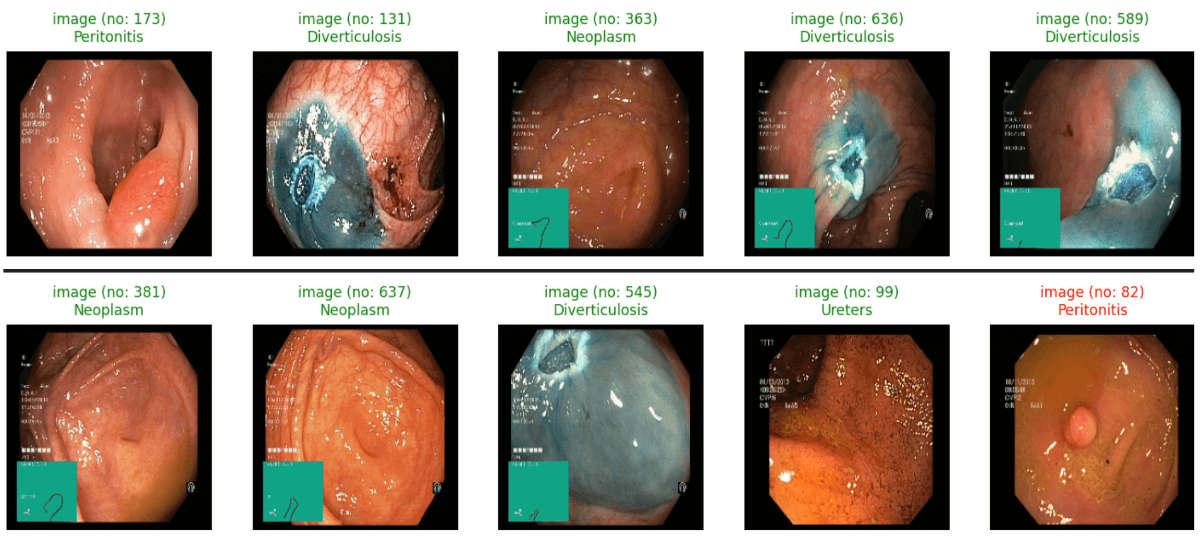

<br>

## My Another Projects
* [Spam vs Ham Message w/ Gemma 7B Fine-Tuning (LoRA)](https://www.kaggle.com/code/banddaniel/spam-vs-ham-message-w-gemma-7b-fine-tuning-lora)
* [Diamond Detect w/Hybrid Model (ViT,CatBoost,SHAP)](https://www.kaggle.com/code/banddaniel/diamond-detect-w-hybrid-model-vit-catboost-shap)
* [Sign Detection w/Keras YOLO V8](https://www.kaggle.com/code/banddaniel/sign-detection-w-keras-yolo-v8)


In [1]:
from IPython.display import clear_output
!pip uninstall tensorflow -y
!pip install tensorflow==2.13.0
!pip install natsort
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import natsort

import tensorflow as tf
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# A config class with several constant variables
# IMG_SIZE for the efficientnet model
# IMG_SIZE_2 for the mobilenet model

class CONFIG:
    IMG_SIZE= 224, 224
    BATCH_SIZE = 64
    AUTO = tf.data.AUTOTUNE
    SEED = 412

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = natsort.natsorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


def create_full_img_class_df(full_path):
    full_images_path = create_images_list(full_path)
    
    data = pd.DataFrame()
    img_rows = []
    label_rows = []
    
    for i in range(len(full_images_path)):
        x = create_images_list(full_images_path[i])
        img_rows.extend(x)
        label_rows.extend([i]*len(x))
    
    data['image'] = img_rows
    data['label'] = label_rows
    
    return data



# look-up table
classes = {0:'Diverticulosis', 1:'Neoplasm', 2:'Peritonitis', 3:'Ureters'}

full_data = create_full_img_class_df('/kaggle/input/medical-imaging/Medical-imaging-dataset')

# train (train and valid), test splitting
idx = 200
train_data = pd.concat([full_data[full_data['label'] == 0][idx:], full_data[full_data['label'] == 1][idx:], full_data[full_data['label'] == 2][idx:], full_data[full_data['label'] == 3][idx:]])
test_data = pd.concat([full_data[full_data['label'] == 0][:idx], full_data[full_data['label'] == 1][:idx], full_data[full_data['label'] == 2][:idx], full_data[full_data['label'] == 3][:idx]])


# shuffling datasets
train_data = train_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED).reset_index(drop = True)
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED).reset_index(drop = True)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	3200
total test images 	800


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (CONFIG.IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Data augmentation 
def augmentation(img, label):
    img = tf.image.random_flip_left_right(img, seed = CONFIG.AUTO)
    img = tf.image.random_flip_up_down(img, seed = CONFIG.AUTO)
    img = tf.image.random_brightness(img, 0.1, seed = CONFIG.AUTO)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = CONFIG.AUTO)
    
    return img, label

In [6]:
# Creating test dataset loader and tf.dataset

test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO).batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.AUTO))

# <span style="color:#e74c3c;"> Swin Transformer </span> Model

In [7]:
# Creating mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

In [8]:
with stg.scope():
    swin = hub.KerasLayer("/kaggle/input/swin/tensorflow2/tiny-patch4-window7-224-fe/1")
    
    inp = Input(shape= (*CONFIG.IMG_SIZE, 3), dtype = tf.float32)
    X = swin(inp, training = True)
    X = Dropout(0.1)(X)
    X = Dense(128, activation='gelu', name = 'the_feature_layer')(X)
    out = Dense(4, activation='softmax')(X)

    model = Model(inp, out)
    model.compile(optimizer = tf.keras.optimizers.AdamW(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc'])
    my_callbacks = [tf.keras.callbacks.EarlyStopping(min_delta = 0.01, patience = 2)]
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 768)               27519354  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 128)               98432     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 27618302 (105.36 MB)
Trainable params: 98948 (386.52 KB)
Non-trainable params: 27519354 (104.98 MB)
_________________________________________________________________


# <span style="color:#e74c3c;"> 3 KFold </span> Training

In [9]:
fold_hists = []
test_preds = []

FOLDS = 3
EPOCHS = 5

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = CONFIG.SEED)
for i,(train_index, val_index) in enumerate(kf.split(train_data['image'], train_data['label'])):
    print('-'*90)
    print(str(i+1) + '.fold training\n')
    
    X_train_fold = train_data['image'][train_index]
    y_train_fold = train_data['label'][train_index]

    X_val_fold = train_data['image'][val_index]
    y_val_fold = train_data['label'][val_index]
    
    # tf.data datasets
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO)
                     .map(augmentation, num_parallel_calls = CONFIG.AUTO)
                     .shuffle(CONFIG.BATCH_SIZE*10)
                     .batch(CONFIG.BATCH_SIZE)
                     .prefetch(CONFIG.AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO)
                          .map(augmentation, num_parallel_calls = CONFIG.AUTO)
                          .batch(CONFIG.BATCH_SIZE)
                          .prefetch(CONFIG.AUTO))
    
    # training
    hist = model.fit(train_dataset, epochs = EPOCHS, validation_data = validation_dataset, callbacks = my_callbacks)
    fold_hists.append(hist)
    
    # test predictions
    test_take1 = test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1, verbose = 0)
    pred = np.argmax(pred, axis = 1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training

Epoch 1/5
34/34 [==============================] - 413s 12s/step - loss: 1.1331 - acc: 0.5523 - val_loss: 0.7341 - val_acc: 0.7919
Epoch 2/5
34/34 [==============================] - 397s 12s/step - loss: 0.6016 - acc: 0.8289 - val_loss: 0.4247 - val_acc: 0.8800
Epoch 3/5
34/34 [==============================] - 417s 12s/step - loss: 0.4191 - acc: 0.8786 - val_loss: 0.3484 - val_acc: 0.9044
Epoch 4/5
34/34 [==============================] - 408s 12s/step - loss: 0.3439 - acc: 0.8973 - val_loss: 0.3038 - val_acc: 0.8969
Epoch 5/5
34/34 [==============================] - 413s 12s/step - loss: 0.2989 - acc: 0.9095 - val_loss: 0.2416 - val_acc: 0.9231
------------------------------------------------------------------------------------------
2.fold training

Epoch 1/5
34/34 [==============================] - 399s 12s/step - loss: 0.2596 - acc: 0.9217 - val_loss: 0.2513 - val_acc: 0.915

# <span style="color:#e74c3c;"> Training </span> Results

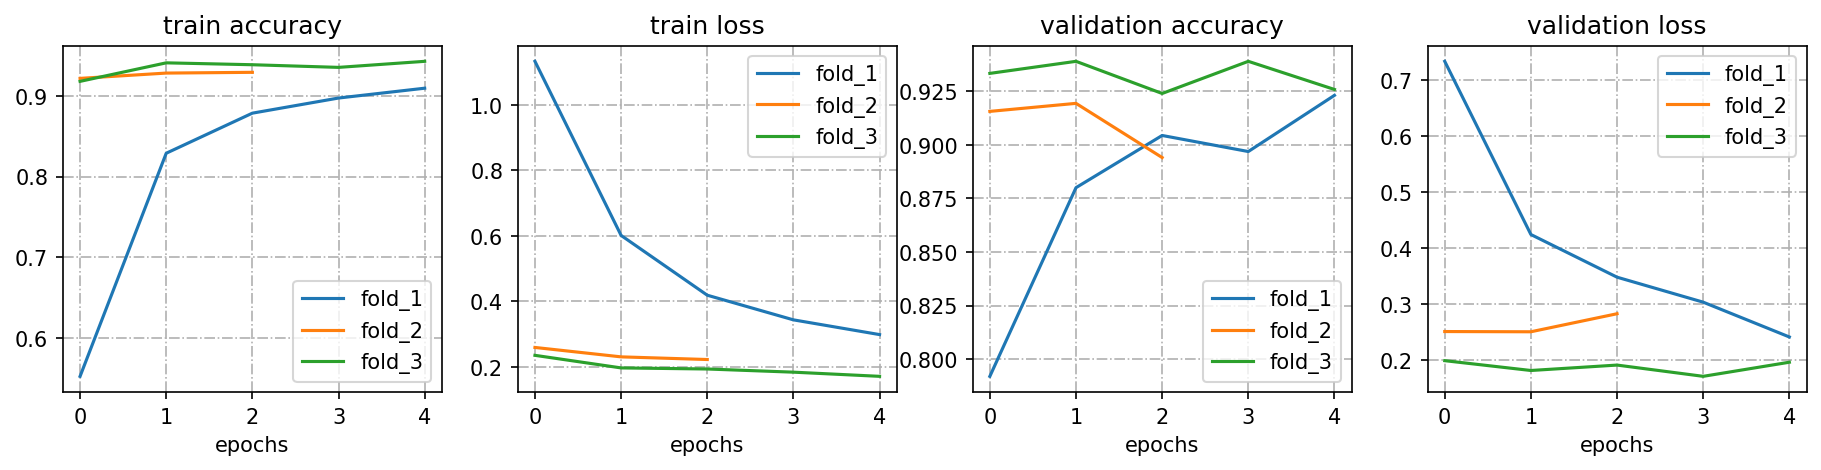

In [10]:
fig, axs = plt.subplots(1,4, figsize = (15,3) ,dpi = 150)

folds_name = []

axs[0].set_title('train accuracy')
axs[0].grid(linestyle = 'dashdot')
axs[0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0].legend(folds_name, fontsize = 10)


axs[1].set_title('train loss')
axs[1].grid(linestyle = 'dashdot')
axs[1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1].plot(fold_hists[i].history['loss'])
axs[1].legend(folds_name, fontsize = 10)


axs[2].set_title('validation accuracy')
axs[2].grid(linestyle = 'dashdot')
axs[2].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[2].plot(fold_hists[i].history['val_acc'])
axs[2].legend(folds_name, fontsize = 10)


axs[3].set_title('validation loss')
axs[3].grid(linestyle = 'dashdot')
axs[3].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[3].plot(fold_hists[i].history['val_loss'])
axs[3].legend(folds_name, fontsize = 10)

# <span style="color:#e74c3c;"> Final </span> Test Predictions

In [11]:
# Calculating the mean of 3 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.round(preds)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [12]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true, y_pred, target_names = list(classes.values())):
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, xticks_rotation="vertical", cmap = 'winter', colorbar = False)

Mean Squared Error :	0.23875
Weighted F1 Score :	0.875
Accuracy Score :	87.500 %
----------------------------------------------------------------------

 Classification Report:
                 precision    recall  f1-score   support

Diverticulosis       0.97      0.94      0.96       200
      Neoplasm       0.81      0.95      0.87       200
   Peritonitis       0.80      0.80      0.80       200
       Ureters       0.94      0.80      0.86       200

      accuracy                           0.88       800
     macro avg       0.88      0.88      0.88       800
  weighted avg       0.88      0.88      0.88       800

----------------------------------------------------------------------

 Confusion Matrix: 



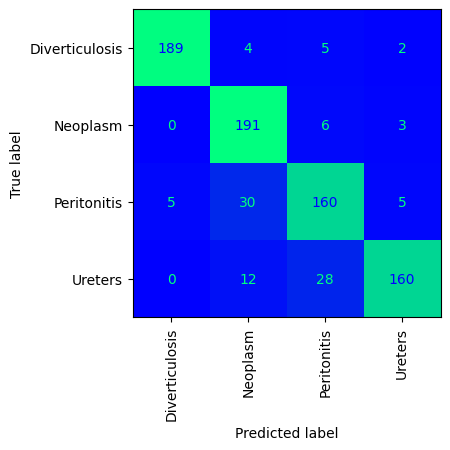

In [13]:
test_true = list(test_data['label'])
test_pred = last_pred

plot_prediction_results(test_true, test_pred)

Test Sample Prediction

# <span style="color:#e74c3c;"> Test Sample </span> Prediction

In [14]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // CONFIG.BATCH_SIZE
    image_idx = idxs-batch_idx * CONFIG.BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

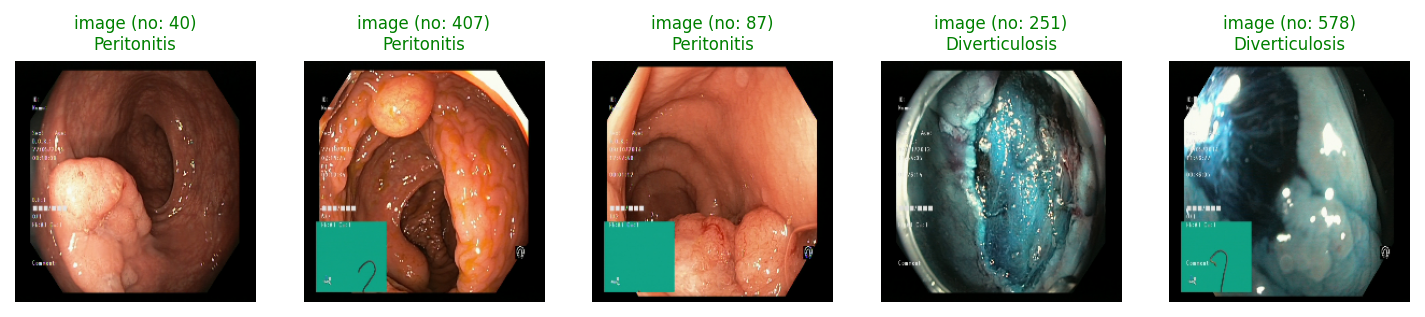

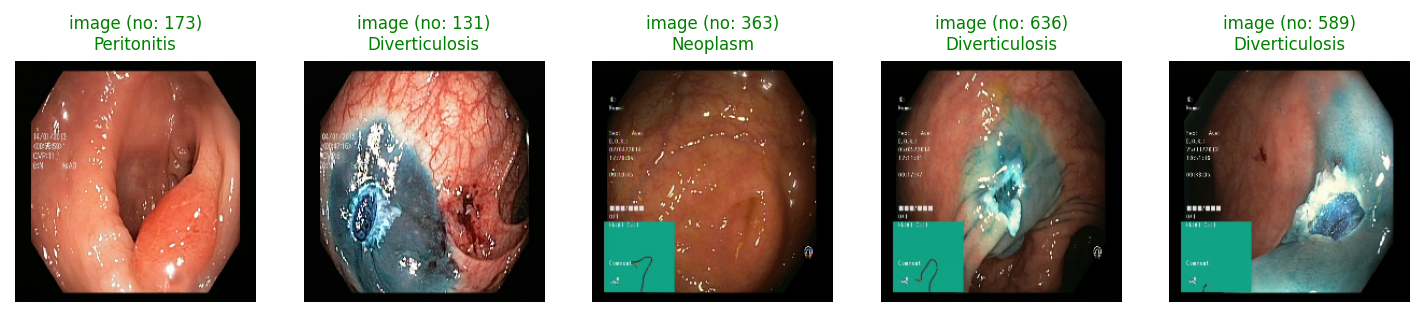

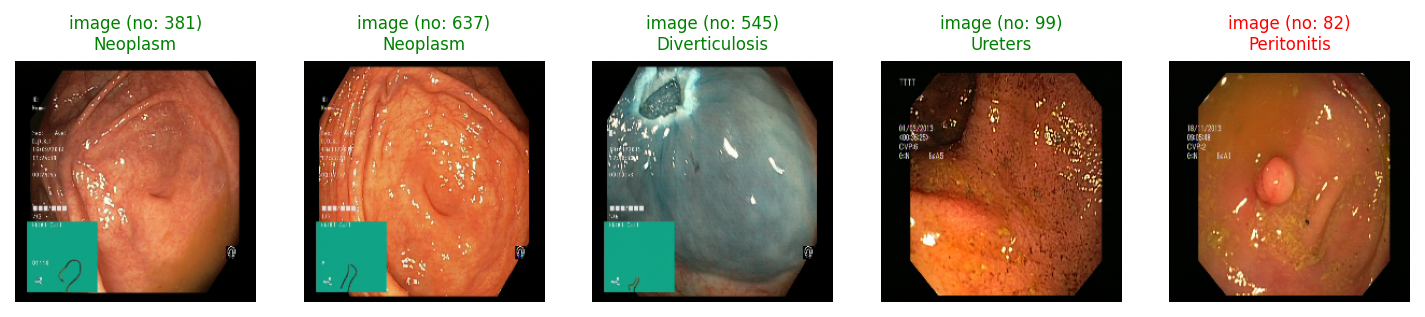

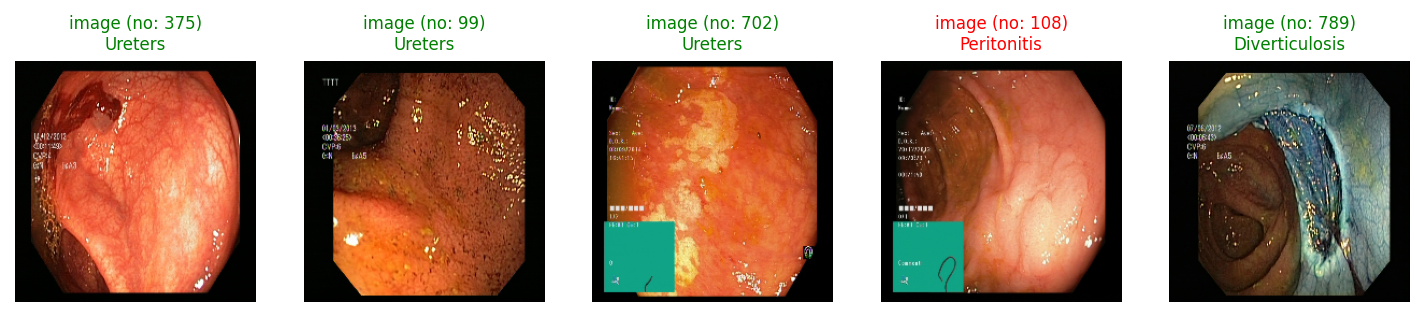

In [15]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 154)
random_test_sample_with_prediction(SEED = 94)
random_test_sample_with_prediction(SEED = 263)
random_test_sample_with_prediction(SEED = 515)